# 14.20 PS1 - CSG Prep#
## Question 0
I spent about 10.5 hours on this pset, although if I had committed to my choice of demand curve models early, and made fewer algebra mistakes, it would have been closer to 7-8.

# Intro #
Before we do anything, we'll load in necessary libraries and our data. The sheet can be easily changed to allow analysis of different markets.

In [70]:
library(readxl)
library(tidyverse)
library(xtable)

In [71]:
mktDData <- read_excel('CSGData2021.xlsx', sheet='MARKET D') # sheet can be changed for diff. market

In [72]:
monoData <- mktDData %>% filter(is.na(mktDData$p2)) %>% select(c('p1', 'q1'))
str(monoData)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	96 obs. of  2 variables:
 $ p1: num  87 100 130 155 190 220 240 268 270 300 ...
 $ q1: num  6258 6162 6022 5794 5702 ...


# Part 1
## Question 1.1 - Demand Curve Estimation
We can now create different models estimating a demand curve. We'll estimate a linear, log-linear, and log-log model. Then, we will visually compare them, and also compare the mean squared error of each.

In [73]:
lin <- p1 ~ q1
loglin <- log(p1) ~ q1
loglog <- p1 ~ log(q1)

#fit and store coefficient and intercept
fit.lin <- lm(lin, data=monoData)
a1 <- fit.lin$coef[1]
b1 <- fit.lin$coef[2]
eq1 <- function(x){a1+b1*x} # used for plotting

fit.loglin <- lm(loglin, data=monoData)
a2 <- fit.loglin$coef[1]
b2 <- fit.loglin$coef[2]
eq2 <- function(x){exp(a2+b2*x)} #used for plotting, expression found from solving for P in model

fit.loglog <- lm(loglog, data=monoData)
a3 <- fit.loglog$coef[1]
b3 <- fit.loglog$coef[2]
eq3 <- function(x){a3+b3*log(x)} #used for plotting, expression found from solving for P in model

Warning message:
“Removed 3 rows containing missing values (geom_point).”

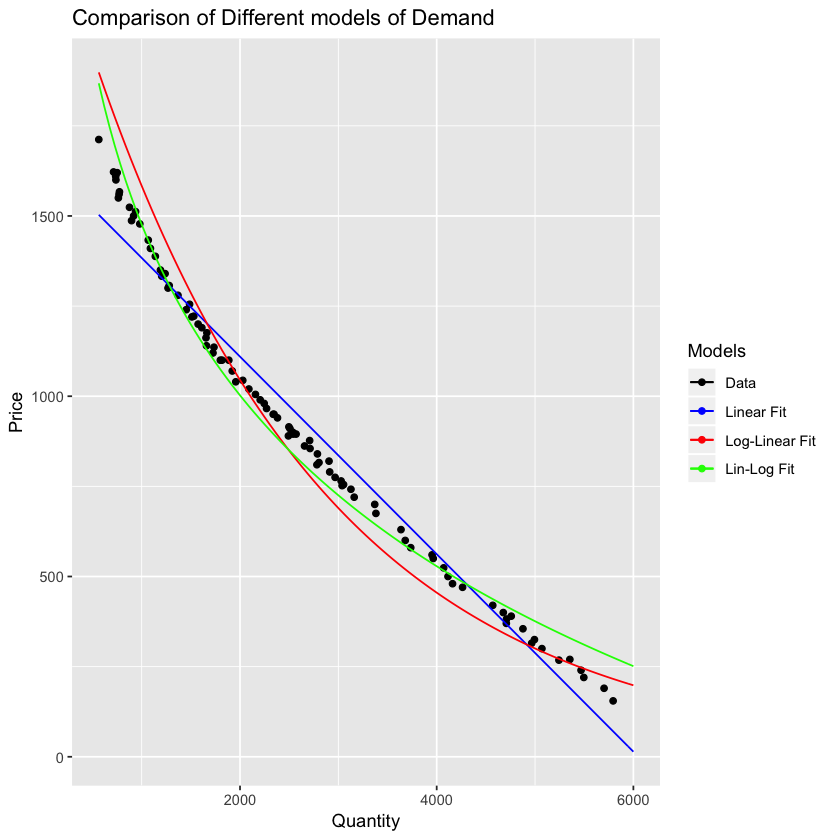

In [74]:
plot <- ggplot(monoData, aes(x=q1, y=p1)) + 
    geom_point(aes(color='Data')) +
    stat_function(fun=eq1, aes(color='Linear Fit')) +
    stat_function(fun=eq2, aes(color='Log-Linear Fit')) +
    stat_function(fun=eq3, aes(color='Log-Log Fit')) +
    xlim(min(monoData$q1),6000) +
    scale_color_manual(name = "Models",
                       values = c("black", "blue", "red", "green"), # Color specification
                       labels = c("Data", "Linear Fit", "Log-Linear Fit", "Lin-Log Fit")) +
    ggtitle("Comparison of Different models of Demand") +
    xlab("Quantity") +
    ylab("Price")

plot

In [75]:
p.actual <- monoData$p1
q.actual <- monoData$q1

res2.loglin <- (eq2(q.actual) - p.actual)^2
res2.loglog <- (eq3(q.actual) - p.actual)^2

MSE.lin <- mean(fit.lin$res^2)
MSE.loglin <- mean(res2.loglin)
MSE.loglog <- mean(res2.loglog)

table <- matrix(0,3,1)
table[1,1] <- MSE.lin
table[2,1] <- MSE.loglin
table[3,1] <- MSE.loglog

rownames(table) <- c("Linear", "Log-Linear", "Log-Lin")
colnames(table) <- c("$MSE$")

tab <- xtable(table)
digits(tab) <- 0
tab


,$MSE$
Linear,5233.332
Log-Linear,7277.756
Log-Lin,3216.712


As we can see, the lin-log and log-linear models are both good candidates for our demand curve. Based on mean squared error, the lin-log model gives us the best fit. Running this analysis on the other markets, this is true in all but one market (market B, where the difference is very small). I will use the linear-log model for the rest of this problem set. That is, demand is given by 
$$P = a + b\log(Q)$$

for $a \approx 6199$ and $b \approx -684$. This model also has attractive properties compared to the log-linear model because it is able to be solved analytically in many cases.

In [76]:
#saving model parameters and defining price and quantity functions for ease of use
a <- a3
b <- b3

price <- function(q){a+b*log(q)}
quantity <- function(p){exp((p-a)/b)}
price(2450)

a
b

(Intercept) 
   863.6827

(Intercept) 
   6199.446

log(q1) 
-683.7353

With this demand curve in mind, we can calculate elasticity of demand along the curve. This is given by 

$$\varepsilon = \frac{\partial Q}{\partial P} \frac{P}{Q} = \frac{P}{b} = \frac{a+b\log(Q)}{b}$$

We can calculate this for a few different values of Q.

In [77]:
elasticity <- function(q){(a+b*log(q))/(b)}

cat("Elasticity at Q=1500:", elasticity(1500), "\n")
cat("Elasticity at Q=3000:", elasticity(3000), "\n")
cat("Elasticity at Q=4500:", elasticity(4500), "\n")



Elasticity at Q=1500: -1.753806 
Elasticity at Q=3000: -1.060659 
Elasticity at Q=4500: -0.6551935 


## Question 1.2 - Profit Maximizing Monopolist

Now, we can use the estimated demand curve to calculate the optimal quantity for a monopolist to produce in this setting. To do this, we set marginal revenue to marginal cost.

The form of marginal revenue is given by

$$MR = \frac{\partial}{\partial Q} (Q(a+b\log(Q)) = a+b+b\log(Q)$$

Setting this equal to marginal cost, we can solve this analytically then use computational methods to check our work. We find that

$$Q = \exp\left(\frac{c_m - a-b}{b}\right)$$

which gives us $Q^* = 2450$. Backing out price from the demand curve, we find that $P^* \approx 863.68$.

In [78]:
mc <- 180 #adjust based on mc
mr <- function(q){a+b+b*log(q)} #adjust based on MR

mrmcDiff <- function(q){mr(q)-mc} #function of marginal revenue - marginal cost
qstar <- uniroot(mrmcDiff, interval=c(500,6000))$root #uses uniroot function to find root of mrmc

cat("Optimal quantity for monopolist:", qstar, "units")

Optimal quantity for monopolist: 2449.811 units

Our computational results reinforce our analytical results.

## Question 1.3 - Profit Maximization With Capacity Constraint ##

We can now take capacity costs (long run costs) into account in our profit maximization problem. In this setup, where our firm is a monopolist, and the demand curve is constant from period to period, with known future costs, we can set our capacity equal to our optimal production quantity for every period. Essentially, this is very similar to what we did for our last exercise, but factoring long term capacity costs. Specifically, we want to solve the problem

$$ \max_{q} \pi = \max_{q} \left[-qc_k+\frac{sc_kq}{(1+r)^4} + \sum_{t=1}^4 \frac{1}{(1+r)^t} \left(q(a+b\log q)-c_mq\right) \right]$$

where $c_k$ is the cost of an additional unit of capacity, $c_m$ is marginal production cost, and $r$ is the interest rate, which we assume to be constant throughout periods, and $s$ is the percentage of value our physical capital retains as scrap. We should discount using the savings rate, rather than the borrowing rate. This more accurately represents the nature of future profits being an alternative to saving now. If we had chosen not to produce any capacity, we would earn interest on our savings equal to the savings rate, so we should discount with the savings rate of 2%.

We can take the derivative of this profit function with respect to $q$, finding our first order condition for profit maximization. 

$$ 0 = -c_k + \frac{sc_k}{(1+r)^4} +\sum_{t=1}^4 \frac{1}{(1+r)^t} \left[ a+b+b\log q-c_m \right] $$

As before, we will solve this analytically and then check our answer with numerical methods. Solving analytically, we find that 

$$ q^* = \exp \left( \frac{c_k - \frac{sc_k}{(1+r)^4} - [a+b-c_m] \sum_{t=1}^4 \frac{1}{(1+r)^t}}{\sum_{t=1}^4 \frac{b}{(1+r)^t}} \right) \approx 1544$$

In [79]:
ck <- 1800 #adjust based on capacity costs
s <- 0.36 #scrap value
r <- 0.02 #interest rate
D <- 1/(1+r) + 1/(1+r)^2 + 1/(1+r)^3 + 1/(1+r)^4
K <- -ck+(s*ck)/(1+r)^4

#derivative of discounted profits, not accounting for capacity costs
discountedMarginalProfits <- function(q){D*(a+b+b*log(q)-mc)}  

#first order condition and root-finding
FOC <- function(q){discountedMarginalProfits(q)+K}
qstar <- uniroot(FOC, interval=c(500,6000))$root

cat("Optimal capacity for monopolist operating in 5 periods:", qstar, "units.")

Optimal capacity for monopolist operating in 5 periods: 1544.301 units.

We can also calculate profits (without accounting for entry costs) at this quantity.

In [80]:
costs <- function(q){q*ck+D*mc*q}
revenues <- function(q){ (s*ck*q)/(1+r)^4 + D*q*(a+b*log(q)) }
profits <- function(q) {revenues(q) - costs(q)}

cat("Profits at optimal quantity:", profits(qstar))

Profits at optimal quantity: 4020554

As discussed before, given long term costs and a constant demand curve, we can find the optimal quantity for each period (it will be the same in each period thanks to constant fundamentals). We would not want to set capacity lower than this, because we would miss out on profits. We do not want to set our capacity higher than this, because we would incur unnecessary costs.

# Part 2
For part 2, I will use a linear demand curve, instead of the lin-log model used in part 1. Therefore, I need to redefine some constants and functions.

In [81]:
a <- a1
b <- b1

price <- function(q){a+b*q}
quantity <- function(p){(p-a)/b}

(Intercept) 
   1657.641

q1 
-0.2739261

## Question 2.1 - Short Run Price Setting

In equilibrium, we would expect firms to set price equal to marginal cost. Therefore, for market D, we have that $P=180$. The two firms would split demand evenly. We can plug our price into the demand curve from above to find optimal quantities. Profits would be equal to 0, because price is equal to marginal cost.

In [66]:
marketQ <- quantity(mc)
firmQ <- marketQ/2

cat("Market quantity:", marketQ, "units. \n")
cat("Firm quantity:", firmQ, "units.")

Market quantity: 5394.306 units. 
Firm quantity: 2697.153 units.

## Question 2.2 - Short Run Quantity Setting

First, we find our firm's best response function. We will use a linear demand curve for this problem. The market demand curve is given by 

$$ P = a + bQ$$

for a different $a$ and $b$ from above. This implies that our firm's revenue is given by

$$R_1 = P(Q)q_1 = aq_1 + bq_1^2 + bq_1q_2$$

We can take the derivative of this with respect to $q_1$ to find our marginal revenue, which we set equal to marginal cost.

$$MR_1 = a+2bq_1 + bq_2 = c_m$$

Solving for $q_1$, our best response function is given by

$$q_1^* = \frac{c_m -a - bq_2^*}{2b} $$

The two best response functions are symmetric, so we plug an expression for $q_2^*$ into our BRF to find that

$$q_1^* = \frac{c_m-a -b\left( \frac{c_m-a-bq_1^*}{2b} \right)}{2b} \hspace{10pt} \Rightarrow \hspace{10pt} q_1^* = \frac{c_m-a}{3b} \approx 1798$$

In [67]:
qstar <- (mc - a)/(3*b)
cat("Equilibrium quantity for firm 1:", qstar, "units \n")

pstar <- price(2*qstar)

cat("Equilibrium price:", pstar, "\n")

profits <- function(q){a*q + 2*b*q^2 - mc*q}

cat("Equilibrium profits:", profits(qstar))

Equilibrium quantity for firm 1: 1798.102 units 
Equilibrium price: 672.5471 
Equilibrium profits: 885650

## Question 2.3 Long Run Quantity Setting

### Part a
This should decrease the equilibrium quantity from each firm, because they face higher costs.

### Part b
As in part 1, we can write out a long term profit function that uses PDV to summarize profits over all periods. However, in this section, the long term profit function will include a term for the competitor's quantity. Therefore, maximizing profits will give us a best response function to our competitor's capacity. Like in question 2.2, these best response functions will be symmetric, allowing us to solve for the optimal quantity (and thus the optimal capacity). We will again use the savings rate for all periods, by the same reasoning as in question 1.3. The algebra can get a little heavy here, so I will make the following simplifications

$$ K = -c_k + \frac{c_ks}{(1+r)^4} \hspace{20pt} D = \sum_{t=1}^4 \frac{1}{(1+r)^t}$$

where $K$ is the net cost of each unit of capacity, and $D$ is a discount factor covering all 4 production periods. Therefore, we have 

$$\sum_{t=1}^4 \frac{x}{(1+r)^t} = Dx$$

for all $x$ that are not functions of $t$. Because demand curves and costs are the same in all periods, none of our fundamentals depend on $t$. With that in mind, we construct the profit function of firm 1.

$$ \pi_1 = Kq_1 + D\left[q_1\left(a+b\left(q_1+q_2\right)\right)-c_mq_1\right] $$

Taking the derivative with respect to $q_1$ and setting it equal to 0, we find that

$$\frac{\partial \pi_1}{\partial q_1} = 0 = K + D(a + 2bq_1 + bq_2 -c_m)$$

which implies that

$$q_1^* = \frac{-\frac{K}{D} -a-bq_2^* + c_m}{2b} = \left(-\frac{K}{2bD} + \frac{c_m-a}{2b}\right) - \frac{q_2^*}{2} $$

By symmetry, we have $q_1^* = q_2^*$, so by plugging in we have

$$ q_1^* = q_2^* = \frac{2}{3}\left(-\frac{K}{2bD} + \frac{c_m-a}{2b}\right)$$

In [68]:
qstar <- (2/3)*( -(K/(2*b*D)) + (mc-a)/(2*b))

cat("Equilibrium quantity/capacity for both firms:", qstar, "units \n")
cat("Equilibrium price", price(2*qstar), "\n")

profits <- function(q){K*q + D*(q*(a+b*2*q)-mc*q)}

cat("Equilibrium PDV of profits of both firms:", profits(qstar))

Equilibrium quantity/capacity for both firms: 1414.175 units 
Equilibrium price 882.8822 
Equilibrium PDV of profits of both firms: 2085960

## Question 2.4
### Part a
Because capacity is constrained, and consumers will buy from the cheaper firm up to capacity, our residual demand function is piecewise. Let $K=q^*$ denote the capacity we solved for in question 2.3, $p_1$ be the price set by our firm, and $p_2$ be the price set by the other firm. Then our residual demand is given by

$$q_1 = \begin{cases} \min\left(\frac{p_1-a}{b}, K\right) && p_1 < p_2 \\ \min\left(K, \frac{p_1-a}{b}-K\right) && p_1>p_2 \\ \min\left(K, \frac{p_1-a}{2b}\right) && p_1 = p_2 \end{cases} $$

### Part b
Because our residual demand function is kinked, our best response function will also be kinked. Let $p^*$ denote the price at which market demand is equal to the total quantity produced in question 2.3 (the Cournot quantity, $2K$), and let $\tilde{p}$ denote the price at which market demand is exactly equal to $K$. Note that $p^* < \tilde{p}$. If $p_2 < p^*$, we can set our price as $p=p^*$. Our opponent will then produce up to their capacity (because market demand is greater than their capacity at $p_2$), and we will produce our capacity. If we set our price any higher, we would be missing out on demand. If we set our price any lower, we would be producing the same quantity but selling at a lower price. If $p_2 = p^*$, our best response function from the last problem tell us that our optimal price is also $p^*$. 

If $p^* < p_2 \leq \tilde{p}$, we will set our price to $p_2 - \varepsilon$, for some arbitrarily small $\varepsilon$. We will then produce to capacity. If $p_2 > \tilde{p}$, then we would set our price equal to $\tilde{p}$ and produce to our capacity. 

Therefore, our best response function is given by

$$p_1 = \begin{cases} p^* && p_2 \leq p^* \\ p_2 - \varepsilon && p^* < p_2 \leq \tilde{p} \\ \tilde{p} && p_2 > \tilde{p} \end{cases} $$

### Part c
Because this best response function is symmetric, the Nash equilibrium of the pricing game is $p_1=p_2=p^*$. Below $p^*$, firms are strictly better off responding up to $p^*$. Above $p^*$, firms are better off undercutting each other until reaching $p^*$, similar to a regular Bertrand game. Therefore, the equilibrium quantities are $q_1=q_2=K$. The profits of firm $i$ over the 5 period game are given by

$$ \pi_i = K\left(-c_k + \frac{c_ks}{(1+r)^4}\right) + DK(p^* - c_m)$$

In [69]:
pi <- qstar*(-ck + (ck*s)/(1+r)^4 ) + D*(qstar*(price(2*qstar)-mc))

cat("Profits for each firm:", pi)

Profits for each firm: 2085960

## Question 2.5
Because each firms long run profits are greater than the mean entry costs, this market is in equilibrium at a duopoly. If the firms' profits had been less than entry costs (as they might have been given fewer periods), a duopoly would be unstable, and at least one firm would not enter.